In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Dataset

You can download dataset from here https://drive.google.com/open?id=1PnX8r45umX_lf3okyMMKXFZrhmqwD8rC

In [2]:
train_path = 'Dataset/Cats_Dogs/train'
valid_path = 'Dataset/Cats_Dogs/valid'
test_path = 'Dataset/Cats_Dogs/test'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(224,224),
    classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(224,224),
    classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(224,224),
    classes=['cat', 'dog'], batch_size=10)

Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [4]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [39]:
imgs, labels = next(train_batches)

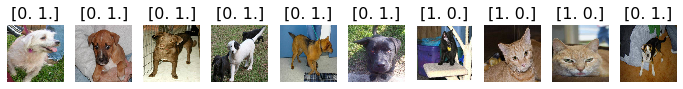

In [40]:
plots(imgs, titles=labels)

# Build and train CNN

In [41]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)),
    Flatten(),
    Dense(2, activation='softmax'),
    ])

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1577088)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 3154178   
Total params: 3,155,074
Trainable params: 3,155,074
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
epochs=5

In [45]:
h=model.fit_generator(generator=train_batches, steps_per_epoch=10, 
    validation_data=valid_batches, validation_steps=10, epochs=epochs, verbose=2)

Epoch 1/5
 - 4s - loss: 1009.8568 - accuracy: 0.4700 - val_loss: 462.3728 - val_accuracy: 0.5000
Epoch 2/5
 - 3s - loss: 179.3467 - accuracy: 0.5500 - val_loss: 425.0397 - val_accuracy: 0.5300
Epoch 3/5
 - 3s - loss: 127.5193 - accuracy: 0.6900 - val_loss: 103.8019 - val_accuracy: 0.5900
Epoch 4/5
 - 3s - loss: 95.9990 - accuracy: 0.7900 - val_loss: 124.7888 - val_accuracy: 0.5400
Epoch 5/5
 - 3s - loss: 23.3920 - accuracy: 0.8900 - val_loss: 15.5211 - val_accuracy: 0.6100


# Loss

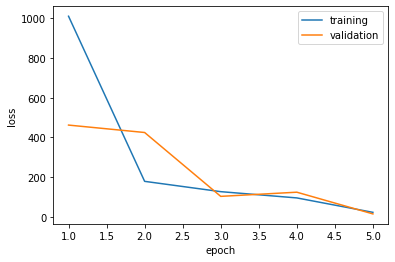

In [46]:
epoch_nums = range(1, epochs+1)
training_loss = h.history["loss"]
validation_loss = h.history["val_loss"]
plt.plot(epoch_nums , training_loss)
plt.plot(epoch_nums , validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training','validation'], loc='upper right')
plt.show()

# Predict

In [47]:
test_imgs, test_labels = next(test_batches)

C:\Users\raiya\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


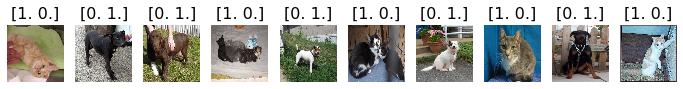

In [48]:
plots(test_imgs, titles=test_labels)

In [49]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 0., 1., 0., 1., 0., 1., 0., 1.], dtype=float32)

In [50]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [52]:
predictions = np.array(predictions)
predictions = np.rint(predictions)
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

# Precision, Recall, F1_Score

In [53]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions[:,0]))

              precision    recall  f1-score   support

         0.0       0.62      1.00      0.77         5
         1.0       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10



# Confusion Matrix

In [54]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',):
    
    print('Confusion Matrix')
    print(cm)

    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion Matrix
[[5 0]
 [3 2]]


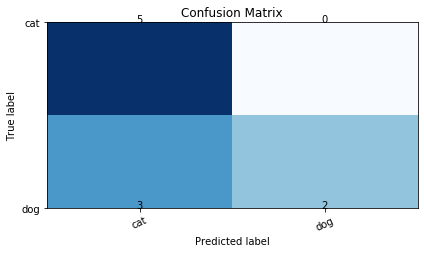

In [55]:
cm = confusion_matrix(test_labels, predictions[:,0])
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Build Fine-tuned VGG16 model

In [21]:
vgg16_model = keras.applications.vgg16.VGG16()

In [22]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
Vgg16_Model = Sequential()
for layer in vgg16_model.layers[:-1]:
    Vgg16_Model.add(layer)

In [24]:
Vgg16_Model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [25]:
for layer in Vgg16_Model.layers:
    layer.trainable = False

In [26]:
Vgg16_Model.add(Dense(2, activation='softmax'))

In [27]:
Vgg16_Model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

# Train the fine-tuned VGG16 model

In [28]:
Vgg16_Model.compile(optimizer=Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
epochs2=5

In [30]:
h2=Vgg16_Model.fit_generator(generator=train_batches, steps_per_epoch=10, 
                    validation_data=valid_batches, validation_steps=10, epochs=epochs2, verbose=2)

Epoch 1/5
 - 106s - loss: 0.8419 - accuracy: 0.6600 - val_loss: 1.5185 - val_accuracy: 0.6800
Epoch 2/5
 - 104s - loss: 0.4887 - accuracy: 0.8000 - val_loss: 1.3655 - val_accuracy: 0.7100
Epoch 3/5
 - 103s - loss: 0.3071 - accuracy: 0.8800 - val_loss: 0.1939 - val_accuracy: 0.7900
Epoch 4/5
 - 103s - loss: 0.2224 - accuracy: 0.9300 - val_loss: 0.9532 - val_accuracy: 0.8100
Epoch 5/5
 - 103s - loss: 0.1588 - accuracy: 0.9600 - val_loss: 0.4738 - val_accuracy: 0.8100


# Loss

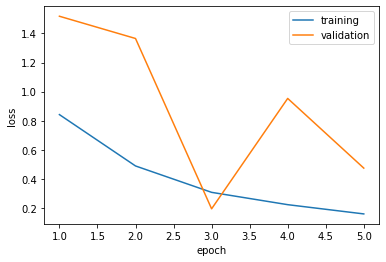

In [31]:
epoch_nums = range(1, epochs2+1)
training_loss = h2.history["loss"]
validation_loss = h2.history["val_loss"]
plt.plot(epoch_nums , training_loss)
plt.plot(epoch_nums , validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training','validation'], loc='upper right')
plt.show()

# Predict

C:\Users\raiya\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


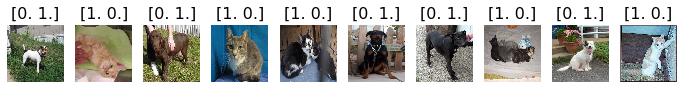

In [32]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [33]:
test_labels = test_labels[:,0]

In [34]:
test_labels

array([0., 1., 0., 1., 1., 0., 0., 1., 0., 1.], dtype=float32)

In [35]:
predictions = Vgg16_Model.predict_generator(test_batches, steps=1, verbose=0)

In [36]:
predictions = np.array(predictions)
predictions = np.rint(predictions)
predictions

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

# Precision, Recall, F1_Score

In [37]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions[:,0]))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91         5
         1.0       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



# Confusion Matrix

Confusion Matrix
[[5 0]
 [1 4]]


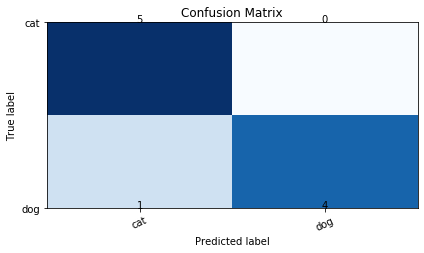

In [38]:
cm2 = confusion_matrix(y_true=test_labels, y_pred=np.round(predictions[:,0]))
cm_plot_labels2 = ['cat','dog']
plot_confusion_matrix(cm=cm2, classes=cm_plot_labels2, title='Confusion Matrix')